In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import os
import gc
import random
import matplotlib.pyplot as plt
import zipfile
import keras
from sklearn.model_selection import train_test_split
from keras import layers
from keras.models import Sequential, Model
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, GlobalMaxPooling2D
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.metrics import MeanSquaredError, RootMeanSquaredError
from keras.utils import to_categorical
from tensorflow.keras.models import load_model
import glob
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import json
from tensorflow.keras.callbacks import Callback, CSVLogger

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load data

In [ ]:
data_path = '/content/drive/MyDrive/GalaxyZoo/compressed_img_target.npz'
loaded_arrays = np.load(data_path)

with tqdm(total=1) as pbar:
    training_images = np.load(data_path, allow_pickle=True)  # allow_pickle=True is necessary for loading npz files with Python 3.7+
    pbar.update(1) # Update progress bar

# Retrieve the arrays
train = loaded_arrays['images']
target = loaded_arrays['target']

print("Shape of the array of training images:", train.shape)

100%|██████████| 1/1 [00:00<00:00, 278.62it/s]


Shape of the array of training images: (61578, 64, 64, 3)


In [ ]:
# First split to separate out the test set
X_temp, X_test, y_temp, y_test = train_test_split(train, target, test_size=0.2, random_state=42)

# Normalize pixel values to range [0, 1]
X_temp = X_temp.astype('float32') / 255
X_test = X_test.astype('float32') / 255
y_temp = y_temp.astype('float32')
y_test = y_test.astype('float32')

# Second split to divide the remaining data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

# Image augmentation and resizing

In [ ]:
# Initialising the ImageDataGenerator with specified augmentations
training_data_generator = ImageDataGenerator(
    zoom_range=0.10,  # Randomly increase or decrease the size of the image by up to 10%
    rotation_range=25,  # Randomly rotate the image between -25 to 25 degrees
    width_shift_range=0.05,  # Shift the image along its width by up to +/- 5%
    height_shift_range=0.05,  # Shift the image along its height by up to +/- 5%
    fill_mode='nearest',  # Fill in newly created pixels after a shift or rotation
)

# Image resizing and data augmentation
def preprocess_and_augment(image, label):
    # Function to resize and augment images
    image_resized = tf.image.resize(image, [224, 224])
    image_batch = tf.expand_dims(image_resized, 0)
    image_augmented = training_data_generator.random_transform(image_batch[0].numpy())
    return image_augmented, label

# Convert the training data to a TensorFlow dataset, augment, and resize
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset = dataset.map(lambda x, y: tf.py_function(preprocess_and_augment, [x, y], [tf.float32, y.dtype]),
                      num_parallel_calls=tf.data.AUTOTUNE)
batch_size = 128
dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

def preprocess_images(images):
    images_resized = tf.image.resize(images, [224, 224])
    return images_resized

# Convert the validation data to a TensorFlow dataset and resize
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.map(lambda x, y: (preprocess_images(x), y), num_parallel_calls=tf.data.AUTOTUNE)
val_batch_size = 128
val_dataset = val_dataset.batch(val_batch_size).prefetch(tf.data.AUTOTUNE)

# Convert the test data to a TensorFlow dataset and resize
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.map(lambda x, y: (preprocess_images(x), y), num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(128)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

# Constrained loss function

In [ ]:
def custom_loss(y_true, y_pred):
    lamda = 0.001
    c1 = tf.abs(tf.reduce_sum(y_pred[:, 0:3], axis=1) - 1) # Class 1 constraint
    c2 = tf.abs(tf.reduce_sum(y_pred[:, 13:15], axis=1) - 1) # Class 6 constraint
    c3 = tf.abs((y_pred[:, 3] + y_pred[:, 4]) - y_pred[:, 1]) # Class 2 constraint
    c4 = tf.abs((y_pred[:, 15] + y_pred[:, 16] + y_pred[:, 17]) - y_pred[:, 10]) # Class 7 constraint
    c5 = tf.abs(tf.reduce_sum(y_pred[:, 18:25], axis=1) - y_pred[:, 13]) # Class 8 constraint
    c6 = tf.abs(tf.reduce_sum(y_pred[:, 25:28], axis=1) - y_pred[:, 3]) # Class 9 constraint
    c7 = tf.abs(tf.reduce_sum(y_pred[:, 5:7], axis=1) - y_pred[:, 4]) # Class 3 constraint
    c8 = tf.abs(tf.reduce_sum(y_pred[:, 7:9], axis=1) - y_pred[:, 4]) # Class 4 constraint
    c9 = tf.abs(tf.reduce_sum(y_pred[:, 28:31], axis=1) - y_pred[:, 7]) # Class 10 constraint
    c10 = tf.abs(tf.reduce_sum(y_pred[:, 9:13], axis=1) - y_pred[:, 7] - y_pred[:, 8]) # Class 5 constraint
    c11 = tf.abs(tf.reduce_sum(y_pred[:, 31:37], axis=1) - y_pred[:, 7]) # Class 11 constraint

    c_loss = lamda*(c1+c2+c3+c4+c5+c6+c7+c8+c9+c10+c11)

    # Base loss (mean squared error)
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))

    # Combine base loss with constraints (you may need to adjust the weighting)
    return mse_loss + c_loss

# VGG16

##Import base model

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

# Define the base model - VGG16
base_model = VGG16(
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False

58889256/58889256 [==============================] - 2s 0us/step


## Stack trainable layers on top

In [ ]:
# Model extension using the functional API
x = base_model.output
# Flatten the output layer to 1 dimension
x = Flatten()(x)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.1
x = Dropout(0.1)(x)
# Output layer
x = Dense(37, activation='sigmoid')(x)

# final model
VGG16 = Model(base_model.input, x)
VGG16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
VGG16.compile(optimizer='adam', loss=custom_loss, metrics=[RootMeanSquaredError()])

## Save weights and training history

In [ ]:
# Directory where checkpoints and history will be saved
checkpoint_dir = '/content/drive/MyDrive/GalaxyZoo/vgg16_checkpoints/'
history_file = '/content/drive/MyDrive/GalaxyZoo/vgg16_training_history.csv'

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Callback for model checkpoints
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'vgg16_epoch_{epoch:02d}_val_loss_{val_loss:.2f}.keras'),
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# Callback for saving training history
csv_logger = CSVLogger(history_file, append=True)

In [ ]:
# EarlyStopping callback
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min', restore_best_weights=True)

## Train model

In [ ]:
history_vgg16 = VGG16.fit(dataset, validation_data=val_dataset, epochs=50, callbacks=[checkpoint_callback, csv_logger, early_stopping_callback])

Epoch 1/50
308/308 [==============================] - ETA: 0s - loss: 0.0359 - root_mean_squared_error: 0.1861
Epoch 1: val_loss improved from inf to 0.01791, saving model to /content/drive/MyDrive/GalaxyZoo/vgg16_resized_checkpoints/vgg16_epoch_01_val_loss_0.02.keras
308/308 [==============================] - 219s 667ms/step - loss: 0.0359 - root_mean_squared_error: 0.1861 - val_loss: 0.0179 - val_root_mean_squared_error: 0.1316
Epoch 2/50
308/308 [==============================] - ETA: 0s - loss: 0.0180 - root_mean_squared_error: 0.1315
Epoch 2: val_loss improved from 0.01791 to 0.01620, saving model to /content/drive/MyDrive/GalaxyZoo/vgg16_resized_checkpoints/vgg16_epoch_02_val_loss_0.02.keras
308/308 [==============================] - 192s 622ms/step - loss: 0.0180 - root_mean_squared_error: 0.1315 - val_loss: 0.0162 - val_root_mean_squared_error: 0.1248
Epoch 3/50
308/308 [==============================] - ETA: 0s - loss: 0.0167 - root_mean_squared_error: 0.1267
Epoch 3: val_loss

# Out of sample performance

In [ ]:
# Evaluate model
test_loss, test_rmse = VGG16.evaluate(test_dataset)
print('Test RMSE:', test_rmse)

97/97 [==============================] - 16s 156ms/step - loss: 0.0138 - root_mean_squared_error: 0.1153
Test RMSE: 0.11528801918029785


# Training and validation history

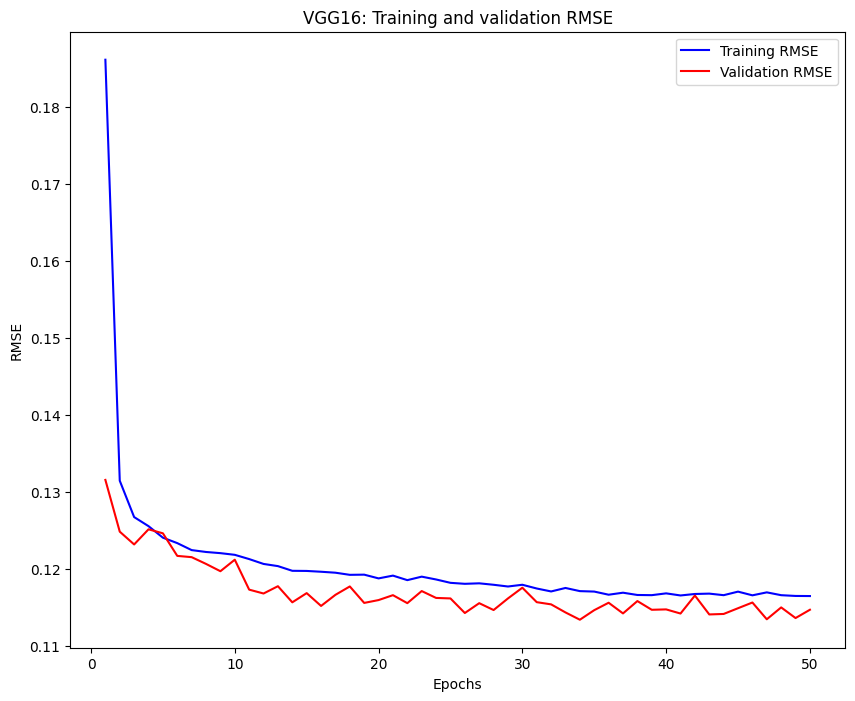

In [ ]:
history_file_path = '/content/drive/MyDrive/GalaxyZoo/vgg16_training_history.csv'
training_history = pd.read_csv(history_file_path)

train_metric = training_history['root_mean_squared_error']
val_metric = training_history['val_root_mean_squared_error']
epochs = range(1, len(train_metric) + 1)

plt.figure(figsize=(10, 8))
plt.plot(epochs, train_metric, 'b', label='Training RMSE')
plt.plot(epochs, val_metric, 'r', label='Validation RMSE')
plt.title('VGG16: Training and validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.savefig('/content/drive/MyDrive/GalaxyZoo/Plots/VGG_trainval.png')
plt.show()